In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
#import os
#import time

#os.environ['TZ'] = 'America/Sao_Paulo'
#time.tzset() 


df = pd.read_csv('data/all_sample.csv', delimiter=';', index_col='timestamp', usecols=['request_per_sec', 'timestamp'])
df.index = pd.to_datetime(df.index, unit='s')
df.fillna(0, inplace=True)

# df.memory_percent = df.memory_percent.apply(lambda x: round(x * 100, 2))
# df.cpu_percent = df.cpu_percent.apply(lambda x: round(x * 100, 2))
# df.req_failed = df.req_failed.apply(lambda x: round(min(100, x), 2))

df

,request_per_sec
timestamp,
2022-05-11 10:50:07,0.00
2022-05-11 10:50:22,0.80
2022-05-11 10:50:37,12.07
2022-05-11 10:50:52,15.27
2022-05-11 10:51:07,20.93
...,...
2022-05-11 13:46:07,0.00
2022-05-11 13:46:22,0.00
2022-05-11 13:46:37,0.00


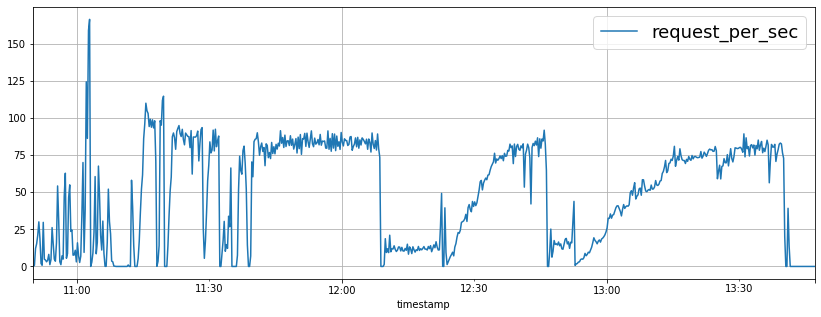

In [2]:
_, ax = plt.subplots(figsize=(14, 5))
df.plot(ax=ax)
ax.legend(prop={'size': 18})
ax.grid()

In [3]:
def create_dataset(dataset, look_back: int = 1):
  data_x, data_y = [], []
  for i in range(len(dataset)-look_back-1):
    data_x.append(dataset[i:(i+look_back),0])
    data_y.append(dataset[i+look_back,0])
  return np.array(data_x), np.array(data_y)


look_back = 1
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = df.values
dataset = dataset.astype('float32')
dataset = scaler.fit_transform(df)

train_size = int(len(df) * .67)
test_size = len(df) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
train_x.shape

(473, 1, 1)

In [4]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
473/473 - 2s - loss: 0.0450 - 2s/epoch - 4ms/step
Epoch 2/100
473/473 - 1s - loss: 0.0206 - 666ms/epoch - 1ms/step
Epoch 3/100
473/473 - 1s - loss: 0.0146 - 513ms/epoch - 1ms/step
Epoch 4/100
473/473 - 1s - loss: 0.0126 - 725ms/epoch - 2ms/step
Epoch 5/100
473/473 - 1s - loss: 0.0121 - 507ms/epoch - 1ms/step
Epoch 6/100
473/473 - 1s - loss: 0.0122 - 516ms/epoch - 1ms/step
Epoch 7/100
473/473 - 1s - loss: 0.0121 - 607ms/epoch - 1ms/step
Epoch 8/100
473/473 - 1s - loss: 0.0121 - 553ms/epoch - 1ms/step
Epoch 9/100
473/473 - 0s - loss: 0.0122 - 489ms/epoch - 1ms/step
Epoch 10/100
473/473 - 1s - loss: 0.0121 - 526ms/epoch - 1ms/step
Epoch 11/100
473/473 - 1s - loss: 0.0121 - 592ms/epoch - 1ms/step
Epoch 12/100
473/473 - 1s - loss: 0.0121 - 638ms/epoch - 1ms/step
Epoch 13/100
473/473 - 0s - loss: 0.0120 - 475ms/epoch - 1ms/step
Epoch 14/100
473/473 - 0s - loss: 0.0120 - 476ms/epoch - 1ms/step
Epoch 15/100
473/473 - 1s - loss: 0.0120 - 501ms/epoch - 1ms/step
Epoch 16/100
473/473 -

In [5]:
# make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = math.sqrt(mean_squared_error(test_y[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

Train Score: 17.89 RMSE
Test Score: 7.58 RMSE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


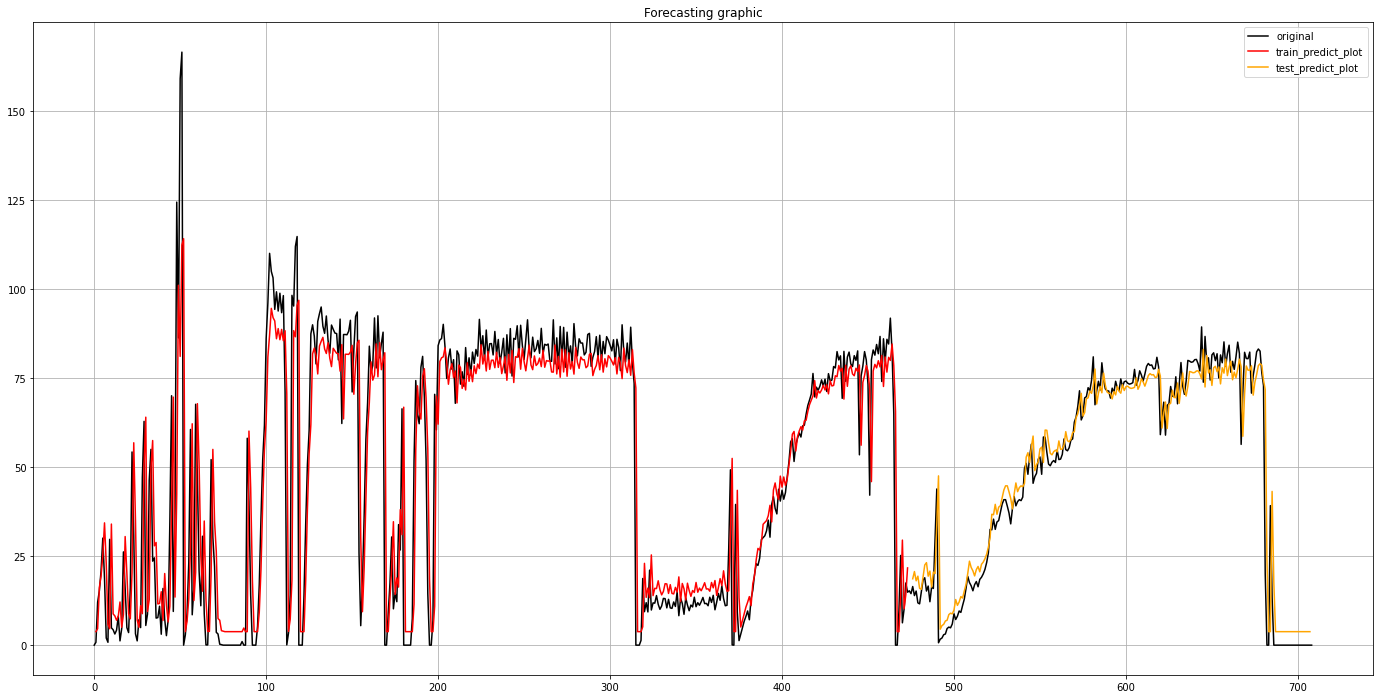

In [6]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# plot baseline and predictions
_, ax = plt.subplots(figsize=(24, 12))
ax.legend(prop={'size': 18})

plt.plot(scaler.inverse_transform(dataset), color='black', label='original')
plt.plot(train_predict_plot, color='red', label='train_predict_plot')
plt.plot(test_predict_plot, color='orange', label='test_predict_plot')
ax.grid()
ax.legend()
plt.title('Forecasting graphic')
plt.show()

In [7]:
############################ FORECAST FUTURO

In [8]:
df = pd.read_csv('data/past_sample.csv', delimiter=';', usecols=['cpu_percent', 'timestamp'])
df['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in df['timestamp']]
df = df.set_index(df['timestamp'])
#df.index = pd.to_datetime(df.index, unit='s', utc=False)
df.fillna(0, inplace=True)

df_real = pd.read_csv('data/future_sample.csv', delimiter=';', usecols=['cpu_percent', 'timestamp'])
df_real['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in df_real['timestamp']]
df_real = df_real.set_index(df_real['timestamp'])
#df_real.index = pd.to_datetime(df_real.index, unit='s', utc=False)
df_real.fillna(0, inplace=True)

y = df['cpu_percent'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 40  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [13]:
# fit the model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)


In [10]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['cpu_percent']].reset_index()
df_past.rename(columns={'index': 'timestamp  ', 'cpu_percent': 'Actual'}, inplace=True)

df_past['timestamp'] = pd.to_datetime(df_past['timestamp'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['timestamp', 'Actual', 'Forecast'])
df_future['timestamp'] = pd.date_range(start=df_past['timestamp'].iloc[-1] + pd.Timedelta(seconds=15), periods=n_forecast, freq='15s')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('timestamp')
results['Real'] = df_real['cpu_percent']

c:\users\denis\desktop\api6\btalert-ai\venv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


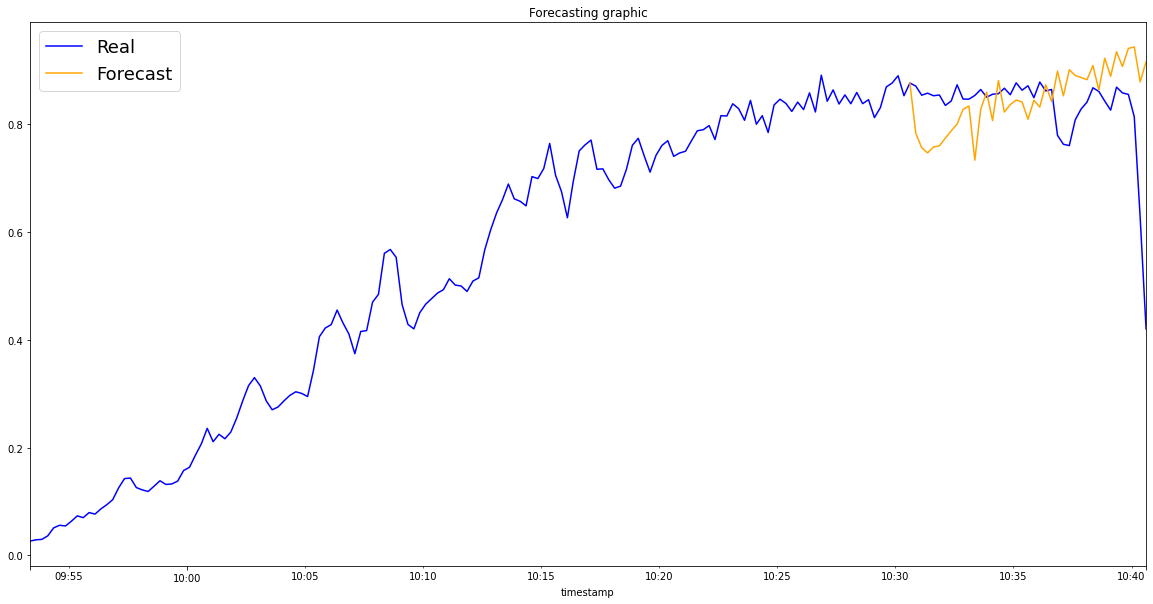

In [11]:
# plot the results
plt.close()

_, ax = plt.subplots(figsize=(20, 10))

results['Real'].plot(color='blue', label='Real')
results['Forecast'].plot(color='orange', label='Forecast')
plt.title('Forecasting graphic')
ax.legend(prop={'size': 18})
plt.show()